In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import math
import os 
import torch.nn.functional as F

import importlib
import data_analysis
importlib.reload(data_analysis)

import autoencoder
importlib.reload(autoencoder)

import utils
importlib.reload(utils)

%matplotlib inline
matplotlib.pyplot.rc('text', usetex=True)
fontsize = 18


print(f'Working in {os.getcwd()}')

Working in /projects/IceDynamics/Stage_M2/code


In [2]:
from utils import get_freer_gpu

device = get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 24197 MB free memory 


In [4]:
from data_analysis import Simulation
from data_analysis import compatible_path
current_directory = compatible_path('../')

simulation = Simulation(current_directory, normalize = True)
time, x, z, u, w, T, umean, wmean, Tmean = map(lambda x: torch.tensor(x).to(device), simulation.import_data())
simulation.image_rgb()

h, l = np.shape(x)
m = len(time)
print(m)
N = h*l*3

6249


# Dataset

In [6]:
from autoencoder import SimuDataset

batch_size = 4

dataset = SimuDataset(simulation, rgb = True, training_ratio = 0.9)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)



tensor(-0.7453, device='cuda:0', dtype=torch.float64) tensor(0.8174, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


# Model

In [ ]:
from autoencoder import ConvolutionalAutoencoder
lr = 1e-4
weight_decay = 0


model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

# Training

In [7]:
num_epoch = 100
output = []
info = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    info.append((epoch, loss.item()))
    output.append((epoch, map, reconstructed))

Epoch: 1, Loss: 0.0130
Epoch: 2, Loss: 0.0044
Epoch: 3, Loss: 0.0058
Epoch: 4, Loss: 0.0035
Epoch: 5, Loss: 0.0049
Epoch: 6, Loss: 0.0031
Epoch: 7, Loss: 0.0021
Epoch: 8, Loss: 0.0045
Epoch: 9, Loss: 0.0025
Epoch: 10, Loss: 0.0024
Epoch: 11, Loss: 0.0021
Epoch: 12, Loss: 0.0032
Epoch: 13, Loss: 0.0032
Epoch: 14, Loss: 0.0026
Epoch: 15, Loss: 0.0019
Epoch: 16, Loss: 0.0028
Epoch: 17, Loss: 0.0024


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


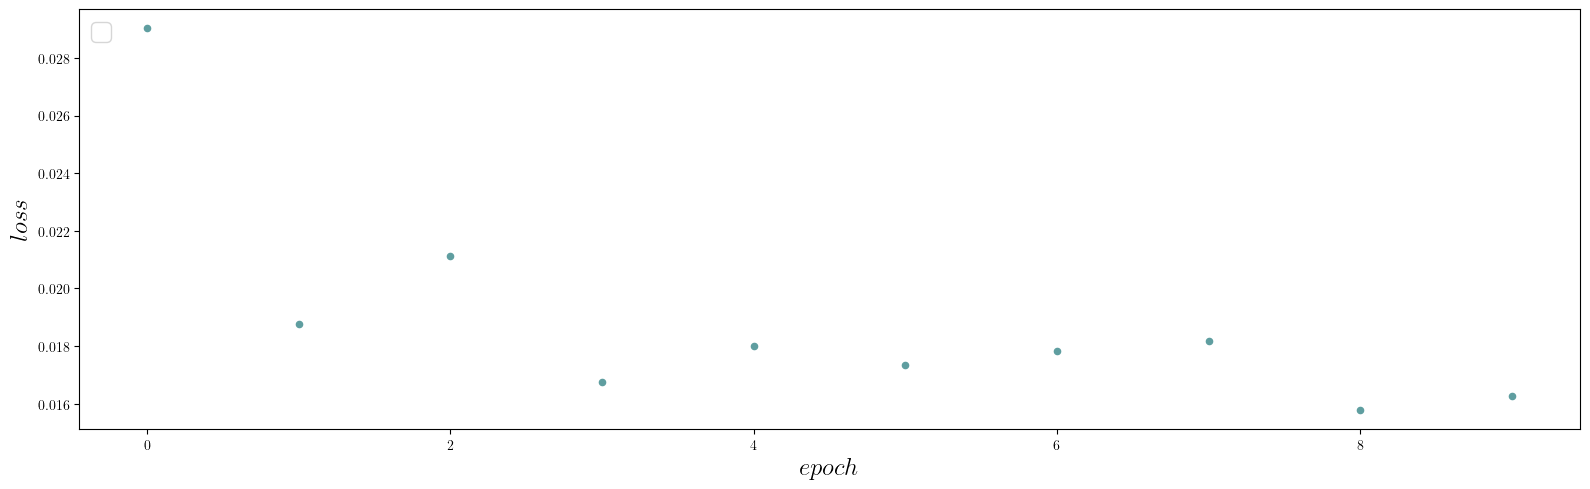

In [64]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(range(len(info)), [info[i][1] for i in range(len(info))], s = 20, c = 'cadetblue')

ax1.set_ylabel(r'$loss$', fontsize= fontsize)
ax1.set_xlabel(r'$epoch$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()

In [65]:
from utils import info_text
directory = f'{current_directory}/results/autoencoder/cnn/'
torch.save(model.state_dict(), directory + f'model_bs{batch_size}_v2.pt')
info_text(directory, batch_size, sizes, num_epoch, info, version = 2)

#### Test

In [23]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [70]:
import torch.nn.functional as F

kernel_size = 3
stride = 1
padding = 1

size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)
n_channels = 64

conv1 = nn.Conv2d(3, n_channels//2, kernel_size, stride = 1, padding = 1).to(device) 
conv2 = nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = 1, padding = 1).to(device) 
conv3 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv4 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv2 = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv3 = nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = 1, padding = 1).to(device)

print(data.shape)

x = conv1(data.float()).to(device)

x = F.relu(x)
x = F.interpolate(x, size = size1)
print('Shape after conv1:', x.shape)
x = conv2(x)

x = F.relu(x)
x = F.interpolate(x, size = size2)
print('Shape after conv2:', x.shape)
x = conv3(x)
x = F.interpolate(x, size = size3)
print('Shape after conv3:', x.shape)
x = conv3(x)
print('Shape after conv4:', x.shape)
x = conv_inv(x)
x = F.interpolate(x, size = size2)
print('Shape after conv_inv1:', x.shape)
x = F.relu(x)
x = conv_inv2(x)
x = F.interpolate(x, size = size1)
print('Shape after conv_inv2:', x.shape)
x = F.relu(x)
x = conv_inv3(x)
x = F.interpolate(x, size = (81,51))
print('Shape after conv_inv3:', x.shape)

torch.Size([4, 3, 81, 51])
Shape after conv1: torch.Size([4, 32, 20, 12])
Shape after conv2: torch.Size([4, 64, 10, 6])
Shape after conv3: torch.Size([4, 64, 3, 2])
Shape after conv4: torch.Size([4, 64, 3, 2])
Shape after conv_inv1: torch.Size([4, 64, 10, 6])
Shape after conv_inv2: torch.Size([4, 64, 20, 12])
Shape after conv_inv3: torch.Size([4, 3, 81, 51])


## Analysis

In [66]:
batch_size = 4
directory = f'{current_directory}/results/autoencoder/cnn/'

with open(directory + f'model_bs{batch_size}_v2_info.txt', 'r') as file:
    content = file.read()
    print(content)

Information about Convolutionnal Autoencoder with batch size 4
size1 = (40, 25)
size2 = (20, 12)
size3 = (10, 6)
size4 = (5, 3)
num epoch = 10
epoch 0, loss 0.029034920036792755
epoch 1, loss 0.01875774934887886
epoch 2, loss 0.021118486300110817
epoch 3, loss 0.016747567802667618
epoch 4, loss 0.018006030470132828
epoch 5, loss 0.017337728291749954
epoch 6, loss 0.017832938581705093
epoch 7, loss 0.018179738894104958
epoch 8, loss 0.01577593758702278
epoch 9, loss 0.01628030464053154



In [41]:
X = simulation.X_rgb
x = np.swapaxes(torch.from_numpy(X), 0, 1).cpu()
x = x.float()

print(x.shape)

torch.Size([6249, 3, 81, 51])


In [67]:
autoencoder = ConvolutionalAutoencoder(device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/cnn/model_bs{batch_size}_v2.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

In [68]:
encoded_data[0]

tensor([[[5.2884e-40, 5.2884e-40, 5.2884e-40],
         [5.2884e-40, 5.2884e-40, 5.2884e-40],
         [5.2884e-40, 5.2884e-40, 5.2884e-40],
         [5.2884e-40, 5.2884e-40, 5.2884e-40],
         [5.2884e-40, 5.2884e-40, 5.2884e-40]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.6885e-40, 5.6885e-40, 5.6885e-40],
         [5.6885e-40, 5.6885e-40, 5.6885e-40],
         [5.6885e-40, 5.6885e-40, 5.6885e-40],
         [5.6885e-40, 5.6885e-40, 5.6885e-40],
         [5.6885e-40, 5.6885e-40, 5.6885e-40]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00],
     

ValueError: Contour levels must be increasing

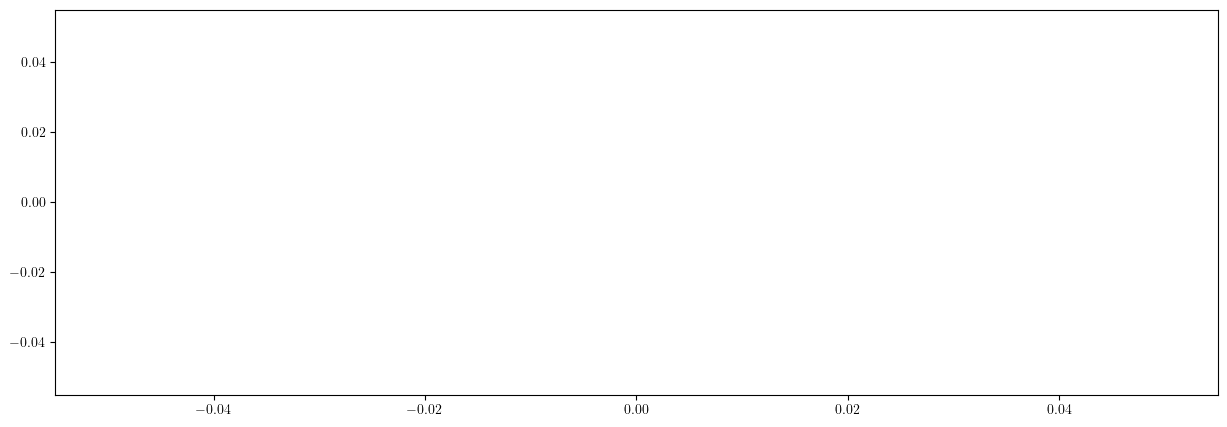

In [69]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True)

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [48]:
decoded_simulation.save_clip(1300, 1400, f'{current_directory}/results/autoencoder/cnn/snapshots/')

from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/cnn/snapshots/', f'{current_directory}/results/gif/cnn_decoded_field_bs{batch_size}_v1.gif', 10)

GIF created at: ..//results/gif/cnn_decoded_field_bs4_v1.gif


In [49]:
uz_decoded, uzmean_decoded = decoded_simulation.UZ()
uz, uzmean = simulation.UZ()

In [36]:
print(time)

tensor([0.1000, 0.1006, 0.1013,  ..., 3.9982, 3.9988, 3.9995], device='cuda:0',
       dtype=torch.float64)


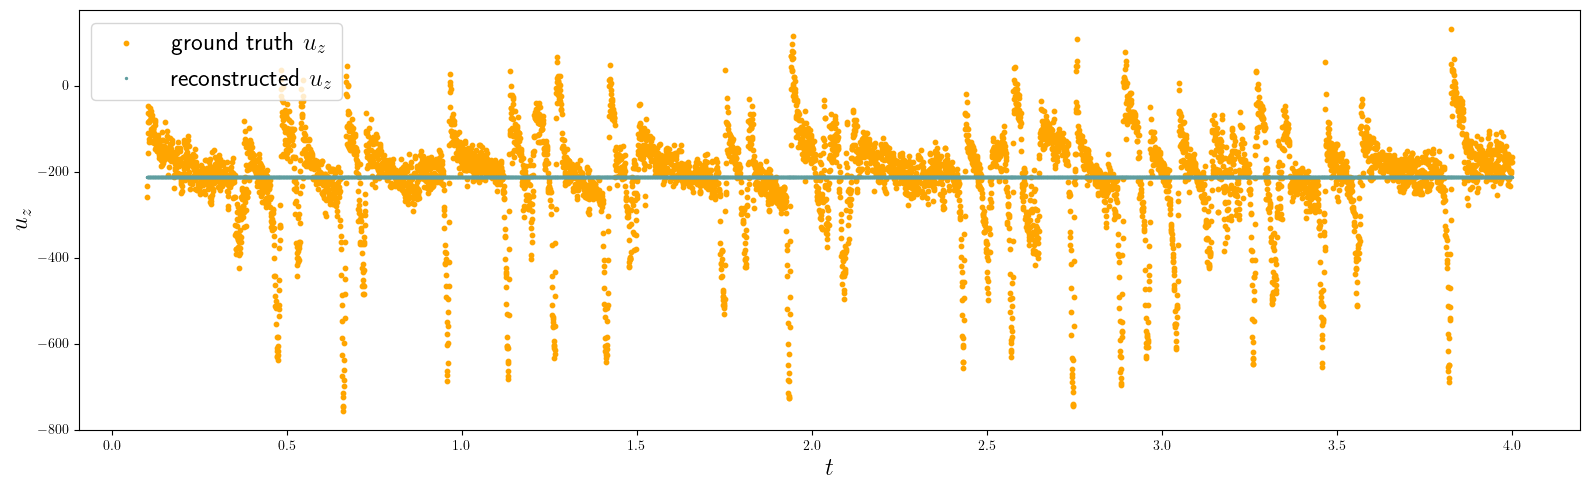

In [50]:
fig, ax1 = plt.subplots(figsize = (16, 5))


ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(time.cpu(), uz_decoded + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')

ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
ax1.set_xlabel(r'$t$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()